In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal, ogr
from netCDF4 import Dataset
import rasterio
import xarray as xr
import os, os.path
from shapely.geometry import Polygon, Point, LineString, MultiPolygon
from math import radians, sin, cos, asin, sqrt, atan2
import re
import csv
from itertools import product
import fiona

%matplotlib inline
directory = '../data'

eez = 5.556

# Read SST

In [72]:
#https://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v5/netcdf/
#sst = xr.open_dataset(directory+"/temp/global/ersst/ersst.v5.201805.nc").to_dataframe()
#sst.reset_index(inplace=True)

#better data than above
#gathered two data points for each month (Oct - May?) to get a general feel for the temp in this growth/harvest period
filelist = os.listdir("../data/temp/global/oisst") 
df_list = [xr.open_dataset('../data/temp/global/oisst/'+file).to_dataframe() for file in filelist]
oisst = pd.concat(df_list)
oisst.reset_index(inplace=True)
oisst['analysed_sst'] -= 273.15
print(oisst.shape)
print(min(oisst.lat), max(oisst.lat),min(oisst.lon),max(oisst.lon))
oisst = oisst[(oisst.lat >32.4) & (oisst.lat <=42.3) & (oisst.lon >= -124) & (oisst.lon <=-117)]
oisst.drop(['time','mask','sea_ice_fraction','lat','lon','analysis_error','nv'],\
               axis=1, inplace=True)
oisst = oisst[np.isfinite(oisst['analysed_sst'])]
print(oisst.shape)
oisst.head()

(33177600, 10)
-89.875 89.875 -179.875 179.875
(11296, 3)


,lat_bnds,lon_bnds,analysed_sst
1411648,32.50,-124.00,18.529993
1411649,32.75,-123.75,18.529993
1411650,32.50,-123.75,18.559991
1411651,32.75,-123.50,18.559991
1411652,32.50,-123.50,18.559991


In [73]:
#create mean, max, and min temps for the data
mean_temps = oisst.groupby(['lat_bnds','lon_bnds']).mean()
max_temps = oisst.groupby(['lat_bnds','lon_bnds']).max()
min_temps = oisst.groupby(['lat_bnds','lon_bnds']).min()
mean_temps.reset_index(inplace=True)
max_temps.reset_index(inplace=True)
min_temps.reset_index(inplace=True)
max_temps['max_temp'] = max_temps.analysed_sst
min_temps['min_temp'] = min_temps.analysed_sst
mean_temps['mean_temp'] = mean_temps.analysed_sst
max_temps.drop(['analysed_sst'], axis=1, inplace=True)
min_temps.drop(['analysed_sst'], axis=1, inplace=True)
mean_temps.drop(['analysed_sst'], axis=1, inplace=True)
print(mean_temps.shape)
mean_temps.head()

(410, 3)


,lat_bnds,lon_bnds,mean_temp
0,32.5,-124.00,16.686864
1,32.5,-123.75,16.615615
2,32.5,-123.50,16.574993
3,32.5,-123.25,16.543119
4,32.5,-123.00,16.536871


In [74]:
#aggregate into one big df
sst = mean_temps.merge(max_temps, on=["lat_bnds","lon_bnds"], how='inner')\
                         .merge(min_temps, on=["lat_bnds","lon_bnds"], how='inner')
#create points from sst
geom = sst.apply(lambda x : Point([x['lat_bnds'],x['lon_bnds']]), axis=1)
sst.drop(['lat_bnds','lon_bnds'], axis=1, inplace=True)
sst = gpd.GeoDataFrame(sst, crs = {'init' :'epsg:4326'}, geometry=geom)

In [75]:
sst.head()
sst.to_pickle('../data/pickles/sst_ca.pkl')

In [4]:
#get values for a given point. We may want to do the kirging option instead of this.
lat = 35.863
lon = -133.72
vertices = (sst_overview.iloc[np.sqrt((sst_overview.lon_bnds-lon)**2+(sst_overview.lat_bnds-lat)**2).argsort()[:3]])
vertices.reset_index(drop=True, inplace = True)
print(vertices)
#set these to find out which row contains the closest pair along the lat/long axes.
lat_pair = None
lon_pair = None
if vertices.iloc[0].lat_bnds == vertices.iloc[1].lat_bnds:
    lat_diff = abs(vertices.iloc[0].lat_bnds - vertices.iloc[2].lat_bnds)
    lon_diff = abs(vertices.iloc[0].lon_bnds - vertices.iloc[1].lon_bnds)
    lat_pair = 1
    long_pair = 2
else:
    lat_diff = abs(vertices.iloc[0].lat_bnds - vertices.iloc[1].lat_bnds)
    lon_diff = abs(vertices.iloc[0].lon_bnds - vertices.iloc[2].lon_bnds)
    lat_pair = 2
    lon_pair = 1
print("lat_diff: {}, lon_diff: {}".format(lat_diff, lon_diff))

point_lat_diff = round(abs(vertices.iloc[0].lat_bnds - lat),2)
point_lon_diff = round(abs(vertices.iloc[0].lon_bnds - lon),2)
print("point_lat_diff: {}, point_lon_diff: {}".format(point_lat_diff, point_lon_diff))
point_lat_pct = point_lat_diff/lat_diff
point_lon_pct = point_lon_diff/lon_diff
print("point_lat_pct: {}, point_lon_pct: {}".format(point_lat_pct, point_lon_pct))

lat_temp_diff = vertices.iloc[lat_pair] - vertices.iloc[0]
lon_temp_diff = vertices.iloc[lon_pair] - vertices.iloc[0]

point_lat_temp = lat_temp_diff*point_lat_pct
point_lon_temp = lon_temp_diff*point_lon_pct
#print("poin_lat_temp: {}, point_lon_temp: {}".format(point_lat_temp, point_lon_temp))

#take into account negative temperature changes
length_fraction = (point_lat_temp + point_lon_temp)/(abs(point_lat_temp)+ abs(point_lon_temp))
point_temp = vertices.iloc[0]+length_fraction*(np.sqrt(point_lat_temp**2+point_lon_temp**2))
print(point_temp)


NameError: name 'sst_overview' is not defined

# Read Bathymetry

In [7]:
#bath = xr.open_dataset("../data/bathymetry/coastal_relief_maps/crm_vol7.nc").to_dataframe()
#bath.reset_index(inplace=True)
#print("max x: {}, min x: {}, max y :{} min y: {}".format(max(bath.x), min(bath.x), max(bath.y), min(bath.y)))
#bath.head()

max x: -117.0, min x: -128.0, max y :44.0 min y: 37.0


,x,y,z
0,-128.0,37.000000,NaN
1,-128.0,37.000833,NaN
2,-128.0,37.001667,NaN
3,-128.0,37.002500,NaN
4,-128.0,37.003333,NaN


In [8]:
#bath.shape (110901601, 3) 
#commented out in favor of the ETOPO1 model with lower resolution

(110901601, 3)

In [24]:
def haversine(p1,p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Source: https://gis.stackexchange.com/a/56589/15183
    """
    lon1 = p1[0]
    lat1 = p1[1]
    lon2 = p2[0]
    lat2 = p2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6373 * c
    return km

In [25]:
#just get the base distance for one point b/c this will be close to the the right scaling
#add half a degee in lat and lon to get the second point
def get_distance_ratio(shape):
    p1 = list(shape.representative_point().coords)[0]
    p2 = (p1[0]+0.5,p1[1]+0.5)
    d_km = haversine(p1,p2)
    #just get the base distance for one point b/c this will be close to the the right scaling for all p2s
    base_coord_d=Point(p1).distance(Point(p2))
    return d_km/base_coord_d

In [26]:
def get_distance_to_object(shape, areas):
    distance_ratio = get_distance_ratio(shape)
    distance = np.min([shape.distance(i) for i in land.geometry])*distance_ratio
    return distance

In [27]:
#import state shapefiles
states = gpd.read_file('../data/state_shapefiles/cb_2017_us_state_20m.shp')
land = states[states['STATEFP'] == '06']
# change the CRS
land = land.set_geometry('geometry').to_crs({'init':'epsg:4326'})

In [28]:
bath2 = xr.open_dataset("../../data/bathymetry/ETOPO1_Ice_g_gmt4.grd").to_dataframe()
bath2.reset_index(inplace = True)
bath2.shape

(233312401, 3)

In [29]:
bath_subset = bath2[(bath2['x'] > -124.5) & (bath2['x'] < -117) & (bath2['y'] >32.5) & (bath2['y']<42)]
bath_subset.reset_index(inplace = True, drop=True)
bath_subset.head()

,x,y,z
0,-124.483333,32.500000,-4324.0
1,-124.483333,32.516667,-4331.0
2,-124.483333,32.533333,-4350.0
3,-124.483333,32.550000,-4368.0
4,-124.483333,32.566667,-4403.0


In [37]:
bath_geom = bath_subset.apply(lambda x : Point([x['x'],x['y']]), axis=1)
bath_subset = gpd.GeoDataFrame(bath_subset, geometry = bath_geom, crs = {'init' : 'epsg:4326'})
#bath_subset.drop(['x','y'], axis=1, inplace = True)
ocean_bathymetry = bath_subset[bath_subset['z']<0]
#ocean_bathymetry.plot(column='z')
print(ocean_bathymetry.shape)
ocean_bathymetry['land_distance'] = ocean_bathymetry.geometry.apply(lambda x: get_distance_to_object(x,land.geometry))
ocean_bathymetry = ocean_bathymetry[ocean_bathymetry['land_distance']<eez]
#ocean_bathymetry.drop(['land_distance'], axis=1, inplace = True)
print(ocean_bathymetry.shape)
ocean_bathymetry.head()

(92615, 4)
(5371, 5)


/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,x,y,z,geometry,land_distance
1614,-124.45,40.400000,-50.0,POINT (-124.45 40.40000000000003),5.423784
1615,-124.45,40.416667,-38.0,POINT (-124.45 40.41666666666669),4.514344
1616,-124.45,40.433333,-32.0,POINT (-124.45 40.43333333333336),4.016070
1617,-124.45,40.450000,-29.0,POINT (-124.45 40.45000000000002),4.158343
1618,-124.45,40.466667,-31.0,POINT (-124.45 40.46666666666669),4.680793


In [21]:
ocean_bathymetry.to_pickle('../data/pickles/bathymetry.pkl')

# Read critical species habitats

In [144]:
#read in black abalone data
black_abalone = gpd.read_file("../data/critical/california/black_abalone/BlackAbFinalCH10272011.shp")
black_abalone['species'] = 'black abalone'
crit_species_areas = black_abalone[['species','geometry']]

leatherback = gpd.read_file("../data/critical/california/leatherback/Final_LeatherbackCH.shp")
leatherback['species'] = 'leatherback sea turtle'
crit_species_areas = crit_species_areas.append(leatherback[['species','geometry']], ignore_index=True)
#crit_species_dfs['leatherback'] = leatherback

stellar_sealions = gpd.read_file("../data/critical/california/stellar_sealions/StellerSLionCritHab_OR_CA.shp")
stellar_sealions['species'] = 'stellar sea lions'
crit_species_areas = crit_species_areas.append(stellar_sealions[['species','geometry']], ignore_index=True)
#crit_species_dfs['stellar_sealions'] = stellar_sealions

#green sturgeon had many shp files, most of which were irrelevant for our immediate purposes.
#I concatenated to relevant ones
#not relevant
#GreenSturgeonCHBypassAreas.shp (interior california)
#GreenSturgeonCHDepartmentofDefense.shp (not in ca)
#GreenSturgeonCHHeadOfTide.shp (interior)
#GreenSturgeonCHMarshAreas.shp (interior)
#GreenSturgeonCHStreams.shp (streams)
#GreenSturgeonCHTribalExclusions.shp

#relevant
#GreenSturgeonCHEstuaries.shp
#GreenSturgeonCHMarineCoastalZones.shp

green_sturgeon = gpd.read_file\
("../data/critical/california/green_sturgeon/GreenSturgeonFinalCH/GreenSturgeonCHEstuaries.shp")
green_sturgeon = green_sturgeon.append(gpd.read_file\
("../data/critical/california/green_sturgeon/GreenSturgeonFinalCH/GreenSturgeonCHMarineCoastalZones.shp"))
green_sturgeon['species'] = 'green sturgeon'
crit_species_areas = crit_species_areas.append(green_sturgeon[['species','geometry']], ignore_index=True)

crit_species_areas.to_pickle('../data/pickles/crit_species.pkl')

KeyboardInterrupt: 

# Read Marine Protected Areas

In [13]:
def eval_geom(x):
    return eval(x)

In [14]:
mpa = pd.read_csv('../data/protected/protected_areas.csv', sep=';')
mpa['Geometry'] = mpa.Geometry.apply(lambda x: eval_geom(x))
mpa.head()

,Name,Geometry
0,Pyramid Point State Marine Conservation Area,"POLYGON ((42 -124.21225, 42 -124.330233, 41.95..."
1,Point St. George Reef Offshore State Marine Co...,"POLYGON ((41.866667 -124.3864833, 41.86667 -12..."
2,Southwest Seal Rock Special Closure,POINT (41.8136 -124.35165)
3,Castle Rock Special Closure,POINT (41.761767 -124.24915)
4,False Klamath Rock Special Closure,POINT (41.593883 -124.11165)


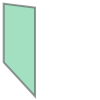

In [22]:
mpa.iloc[0]['Geometry']

In [24]:
a = Polygon([(0,0),(1,0),(0,1)])
b = Polygon([(0,0),(1,1),(1,0)])
c = Polygon([(0,0),(-1,0),(0,-1)])
d = Polygon([(0,3),(0,4),(1,3)])
e = LineString([(-1,1),(-2,2)])
f = Point(1,-1)

In [30]:
f.distance(a)

1.0

In [15]:
mpa.to_pickle('../data/pickles/mpa.pkl')

# Read Occupation Data

In [3]:
#read NES data
#Nonemp15co.txt
all_nes = pd.DataFrame()
for f in os.listdir('../../data/occupation/nonemployer_stats/csv_files'):
    nes = pd.read_csv('../../data/occupation/nonemployer_stats/csv_files/' + f)
    nes.columns = nes.columns.str.lower()
    #the files don't come with years, so I add it here
    nes['year'] = '20'+f[6:8]
    all_nes = all_nes.append(nes)

#Below are the NAICS codes for industries relevant to this analysis
#311119 Kelp meal and pellets, animal feed manufacturing

#1125 Aquaculture
#11251 Aquaculture
#112511 Finfish Farming and Fish Hatcheries
#112512 Shellfish Farming
#112519 Other Aquaculture

#1141 Fishing
#11411 Fishing
#114111 Finfish Fishing
#114112 Shellfish Fishing
#114119 Other Marine Fishing

#more clarification on a few
#112519 Other Aquaculture
#This U.S. industry comprises establishments primarily engaged in (1) farm raising of aquatic animals
#(except finfish and shellfish) and/or (2) farm raising of aquatic plants. Alligator, algae, frog, seaweed, 
#or turtle production is included in this industry.
#112519 Seaweed farming
#114119 Seaweed gathering

#relevant naics occupation codes
occupations = [311119,1125,11251,112511,112512,112519,11411,114111,114112,114119]

#Read fips codes
fips_codes = pd.read_csv('../../data/occupation/fips_county.csv')

#filter data
all_nes = all_nes.merge(fips_codes, left_on = ["st","cty"], right_on=["fips_state","fips_county"])
all_nes = all_nes[all_nes['State'] == 'CA']
all_nes = all_nes[all_nes['naics'].isin(list(map(str,occupations)))]
all_nes.drop(["st","cty","rcptot_n_f","rcptot_f","rcptot","fips_class_code"], axis=1, \
            inplace=True)
print(all_nes.shape)
all_nes.head()

(562, 8)


,estab,estab_f,naics,year,State,fips_state,fips_county,name
557938,50,NaN,11411,2006,CA,6,1,Alameda County
558406,46,NaN,11411,2007,CA,6,1,Alameda County
558867,58,NaN,11411,2008,CA,6,1,Alameda County
559328,55,NaN,11411,2009,CA,6,1,Alameda County
559791,42,NaN,11411,2010,CA,6,1,Alameda County


In [90]:
#only naics code 11411 is in data for CA
all_nes['naics'].unique()
all_nes.dtypes

estab           int64
estab_f        object
naics          object
year           object
State          object
fips_state      int64
fips_county     int64
name           object
dtype: object

In [4]:
#read qcew data
all_qcew = pd.DataFrame()
for f in os.listdir('../../data/occupation/qcew'):
    qcew = pd.read_csv('../../data/occupation/qcew/'+f)
    qcew = qcew[list(qcew.columns[:10])]
    qcew.drop(['own_code','qtr',], axis=1,inplace=True)
    qcew = qcew[qcew['area_fips'].str.isnumeric()]
    qcew['fips_county'] = qcew['area_fips'].str[-3:].astype(int)
    qcew['fips_state'] = qcew['area_fips'].apply(lambda x: x[:2] if len(x)>4 else x[:1]).astype(int)
    qcew = qcew.merge(fips_codes, on=["fips_state","fips_county"])
    qcew = qcew[qcew['State'] == 'CA']
    all_qcew = all_qcew.append(qcew)
all_qcew.dtypes

NameError: name 'fips_codes' is not defined

# Read in Census Population Data

In [18]:
census = pd.read_csv('../../data/population/co-est2017-alldata.csv',encoding='ISO-8859-1')
census = census[list(census.columns[3:17])]
census.drop(['CENSUS2010POP','ESTIMATESBASE2010'], inplace=True, axis=1)
#rename columns so we can merge datasets
newcolnames = ['2010','2011','2012','2013','2014','2015','2016','2017']
oldcolnames = ['POPESTIMATE'+i for i in newcolnames]
census.rename(columns = dict(zip(oldcolnames,newcolnames)), inplace=True)
census.head()

,STATE,COUNTY,STNAME,CTYNAME,2010,2011,2012,2013,2014,2015,2016,2017
0,1,0,Alabama,Alabama,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747
1,1,1,Alabama,Autauga County,54750,55199,54927,54695,54864,54838,55278,55504
2,1,3,Alabama,Baldwin County,183110,186534,190048,194736,199064,202863,207509,212628
3,1,5,Alabama,Barbour County,27332,27351,27175,26947,26749,26264,25774,25270
4,1,7,Alabama,Bibb County,22872,22745,22658,22503,22533,22561,22633,22668


In [19]:
#convert the columns to rows so that we can merge datasets
census = pd.melt(census, id_vars = ['STATE','COUNTY','STNAME','CTYNAME'], var_name='year', value_name='population')
census = census.sort_values(['STATE','COUNTY'])
census.head(10)
census.dtypes

STATE          int64
COUNTY         int64
STNAME        object
CTYNAME       object
year          object
population     int64
dtype: object

In [20]:
#merge the census data with the nes data to get the percent of county workforce in a relevant occupation
all_nes = all_nes.merge(census, left_on=['fips_state','fips_county','year'],\
                        right_on=['STATE', 'COUNTY','year'], how='inner')
all_nes['pct'] = all_nes['estab']/all_nes['population']
all_nes.head()

,estab,estab_f,naics,year,State,fips_state,fips_county,name,STATE,COUNTY,STNAME,CTYNAME,population,pct
0,42,NaN,11411,2010,CA,6,1,Alameda County,6,1,California,Alameda County,1513402,0.000028
1,71,NaN,11411,2011,CA,6,1,Alameda County,6,1,California,Alameda County,1532215,0.000046
2,63,NaN,11411,2012,CA,6,1,Alameda County,6,1,California,Alameda County,1556648,0.000040
3,65,NaN,11411,2013,CA,6,1,Alameda County,6,1,California,Alameda County,1582936,0.000041
4,64,NaN,11411,2014,CA,6,1,Alameda County,6,1,California,Alameda County,1611572,0.000040


In [22]:
all_nes.to_pickle('../data/pickles/nes_occupation.pkl')

In [21]:
#merge census data to qcew data
#convert year to str for comparison
all_qcew['year'] = all_qcew.year.astype(str)
all_qcew = all_qcew.merge(census, left_on=['fips_state','fips_county','year'],\
                          right_on=['STATE','COUNTY','year'], how='inner')
all_qcew['estab_pct'] = all_qcew['annual_avg_estabs']/all_qcew['population']
all_qcew['emp_pct'] = all_qcew['annual_avg_emplvl']/all_qcew['population']
all_qcew.head()

,area_fips,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,fips_county,fips_state,State,name,fips_class_code,STATE,COUNTY,STNAME,CTYNAME,population,estab_pct,emp_pct
0,06007,11251,77,0,2013,N,1,0,7,6,CA,Butte County,H1,6,7,California,Butte County,221768,0.000005,0.000000
1,06015,11251,77,0,2013,N,1,0,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.000036,0.000000
2,06015,11411,77,0,2013,NaN,39,81,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.001401,0.002911
3,06019,11251,77,0,2013,N,4,0,19,6,CA,Fresno County,H1,6,19,California,Fresno County,953787,0.000004,0.000000
4,06023,11251,77,0,2013,NaN,6,19,23,6,CA,Humboldt County,H1,6,23,California,Humboldt County,134444,0.000045,0.000141


In [23]:
all_qcew.to_pickle('../data/pickles/qcew_occupation.pkl')

# Read unemployment data

In [22]:
unemployment = pd.read_csv('../../data/occupation/unemployment/unemployment.csv')
unemployment = unemployment.groupby(['fips_state','fips_county']).mean()
unemployment.reset_index(inplace=True)
unemployment = unemployment[unemployment.fips_state == 6]
print(unemployment.shape)
unemployment.head()
unemployment.to_pickle('../data/pickles/unemployment.pkl')

(58, 3)


In [4]:
fips_codes.head()

,State,fips_state,fips_county,name,fips_class_code
0,AL,1,1,Autauga County,H1
1,AL,1,3,Baldwin County,H1
2,AL,1,5,Barbour County,H1
3,AL,1,7,Bibb County,H1
4,AL,1,9,Blount County,H1


# Read County shapefiles

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,6,75,00277302,0500000US06075,06075,San Francisco,06,121485107,479107241,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
1,25,25,00606939,0500000US25025,25025,Suffolk,06,150855462,160479920,"POLYGON ((-71.19115499999999 42.283059, -71.15..."
2,31,7,00835826,0500000US31007,31007,Banner,06,1932676697,397069,"POLYGON ((-104.052825235239 41.69795385306401,..."
3,37,181,01008591,0500000US37181,37181,Vance,06,653705784,42187365,"POLYGON ((-78.497783 36.514477, -78.4572778962..."
4,48,421,01383996,0500000US48421,48421,Sherman,06,2390651189,428754,"POLYGON ((-102.162463 36.500326, -102.03233901..."


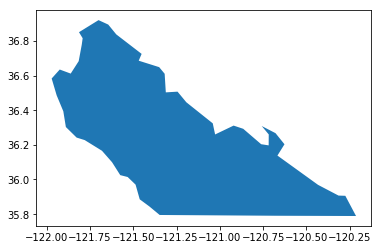

In [29]:
counties = gpd.read_file('../../data/county_shapefiles/cb_2017_us_county_20m/cb_2017_us_county_20m.shp')
counties['STATEFP'] = counties['STATEFP'].astype(int)
counties['COUNTYFP'] = counties['COUNTYFP'].astype(int)
counties[(counties['STATEFP']==6) & (counties.COUNTYFP == 53)]['geometry'].plot()
counties.head()

In [30]:
ca_counties = counties[counties['STATEFP'] == int(fips_codes[fips_codes['State']=='CA']['fips_state'].unique())]
ca_counties.drop(['COUNTYNS','AFFGEOID','GEOID','LSAD','ALAND','AWATER'], axis=1, inplace=True)
ca_counties.head()

/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,STATEFP,COUNTYFP,NAME,geometry
0,6,75,San Francisco,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
705,6,87,Santa Cruz,"POLYGON ((-122.317682 37.186945, -122.152774 3..."
713,6,31,Kings,"POLYGON ((-120.315068 35.907186, -119.959058 3..."
899,6,85,Santa Clara,"POLYGON ((-122.190402 37.431472, -122.144933 3..."
915,6,21,Glenn,"POLYGON ((-122.911794 39.799485, -122.046471 3..."


In [31]:
ca_counties.to_pickle('../data/pickles/ca_counties.pkl')

# Read XBT bathymetry data

In [190]:
#with open('../../data/bathymetry/xbt/ca/xbts7412.csv') as f:
#    reader=csv.reader(f)
#    counter = 0
#    a = []
#    for row in reader:
#        #print("counter",counter)
#        if len(row) != 25:
#            #print("counter",counter)
#            a.append(len(row))
#        counter +=1
#    plt.hist(a, bins = 50,range=(10,60))
xbt = pd.read_csv('../../data/bathymetry/xbt/ca/xbts7412.csv')
xbt = xbt.append(pd.read_csv('../../data/bathymetry/xbt/ca/xbts7312.csv'))
xbt = xbt.append(pd.read_csv('../../data/bathymetry/xbt/ca/xbts7311.csv'))

In [191]:
xbt = xbt[xbt['Year'] >1996]
xbt = xbt[(xbt['Latitude'] <42.2) & (xbt['Latitude']>32.5) & (xbt['Longitude'] <-117.0) & (xbt['Longitude']>-124.5)] 

In [192]:
xbt.head()
#xbt.iloc[:1000,:26].head(1000)

,ISO_country,Cruise_ID,Latitude,Longitude,Year,Month,Day,Time,WOD_unique,Temp_0m,...,Temp_8100m,Temp_8200m,Temp_8300m,Temp_8400m,Temp_8500m,Temp_8600m,Temp_8700m,Temp_8800m,Temp_8900m,Temp_9000m
19761,US,127670,40.372,-124.487,1998,7,17,2.57,8131664,13.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19775,US,127670,41.133,-124.418,1998,7,18,18.92,8131727,13.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19776,US,127670,41.135,-124.338,1998,7,18,19.23,8131729,13.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19781,US,127670,41.275,-124.398,1998,7,19,5.78,8131746,14.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19783,US,127670,41.633,-124.350,1998,7,19,19.37,8131762,13.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Temp_0m,Temp_5m,Temp_10m,Temp_15m,Temp_20m,Temp_25m,Temp_30m,Temp_35m,Temp_40m,Temp_45m,...,Temp_8200m,Temp_8300m,Temp_8400m,Temp_8500m,Temp_8600m,Temp_8700m,Temp_8800m,Temp_8900m,Temp_9000m,geometry
0,13.40,11.52,11.47,11.53,10.87,10.69,10.53,10.00,9.81,9.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.487 40.372)
1,13.45,12.02,11.94,11.86,11.06,10.45,9.88,9.90,9.75,9.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.418 41.133)
2,13.18,12.22,11.91,10.63,9.69,9.49,9.17,9.07,9.06,9.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.338 41.135)
3,14.24,12.22,10.69,9.67,9.38,9.15,8.86,8.86,8.87,8.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.398 41.275)
4,13.48,12.12,11.31,11.09,11.00,10.73,10.68,10.84,10.28,9.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.35 41.633)


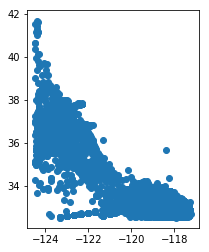

In [193]:
xbt_geom = xbt.apply(lambda x : Point([x['Longitude'],x['Latitude']]), axis=1)
xbt = gpd.GeoDataFrame(xbt, geometry = xbt_geom, crs = {'init' : 'epsg:4326'})
xbt = xbt.iloc[:,9:] #drop certain columns
xbt.reset_index(inplace=True, drop=True)
xbt.plot()
xbt.head()

In [113]:
#xbt_sub = xbt[xbt['Latitude'] == 49.172]
#xbt_sub[xbt_sub.duplicated(['Latitude','Latitude'], keep = False)]
#xbt[xbt.duplicated(['Latitude','Latitude'], keep = False)]
#test = pd.DataFrame({'col1':[0,0,2,2,4,5,4], 'col2':[0,1,3,3,6,7,6]})
#test.head()
#test[test.duplicated(['col1','col2'], keep = False)]

In [194]:
#def strip_depth_from_col(colname):
#    regex = 'Temp_(\d+)m'
#    depth = int(re.match(regex,colname).groups()[0])
#    return depth
    
def find_seafloor(cols):
    rock_bottom = np.max(np.where(cols[:-1].notnull())) # don't check for the geometry column
    temp_seafloor = cols[rock_bottom]
#    z_seafloor = strip_depth_from_col(cols.index[rock_bottom])
    return cols[rock_bottom]#, z_seafloor

In [195]:
xbt['temp_floor'] = xbt.apply(find_seafloor, axis=1)
xbt.head()

,Temp_0m,Temp_5m,Temp_10m,Temp_15m,Temp_20m,Temp_25m,Temp_30m,Temp_35m,Temp_40m,Temp_45m,...,Temp_8300m,Temp_8400m,Temp_8500m,Temp_8600m,Temp_8700m,Temp_8800m,Temp_8900m,Temp_9000m,geometry,temp_floor
0,13.40,11.52,11.47,11.53,10.87,10.69,10.53,10.00,9.81,9.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.487 40.372),9.56
1,13.45,12.02,11.94,11.86,11.06,10.45,9.88,9.90,9.75,9.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.418 41.133),8.71
2,13.18,12.22,11.91,10.63,9.69,9.49,9.17,9.07,9.06,9.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.338 41.135),8.76
3,14.24,12.22,10.69,9.67,9.38,9.15,8.86,8.86,8.87,8.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.398 41.275),8.41
4,13.48,12.12,11.31,11.09,11.00,10.73,10.68,10.84,10.28,9.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.35 41.633),9.28


In [202]:
#plt.hist(xbt.temp_floor, bins=50)
xbt = xbt.iloc[:,-2:]
xbt.head()
xbt.to_pickle('../data/pickles/temp_floor.pkl')

# Read Kelp Locations

In [6]:
kelp_forest = xr.open_dataset("../data/kelp_biomass/LandsatKelpBiomass_2017.nc").to_dataframe() #biomass in kg
print("Kelp Forest Coordinate Bounds: \n [({},{}), ({},{})]"\
      .format(min(kelp_forest.lat), min(kelp_forest.lon), max(kelp_forest.lat), max(kelp_forest.lon)))
areas_with_kelp = kelp_forest[(kelp_forest.year == 2015) & (kelp_forest.quarter == 4) & (kelp_forest.biomass > 0)]
geom = areas_with_kelp.apply(lambda x : Point([x['lat'],x['lon']]), axis=1)
kelper = gpd.GeoDataFrame(areas_with_kelp, crs = {'init' :'epsg:4326'}, geometry=geom) #geom is a Series
kelper = kelper.reset_index()
kelper = kelper.iloc[:, [2, 3, 6, 12]]
kelper.to_pickle('../data/pickles/kelp_biomass.pkl')
kelper.head()

Kelp Forest Coordinate Bounds: 
 [(32.35732391,-122.3298817), (37.11449796,-117.1293993)]


,lat,lon,biomass,geometry
0,32.519277,-117.142836,265.0,POINT (32.51927713 -117.1428356)
1,32.519547,-117.143155,635.0,POINT (32.5195474 -117.1431554)
2,32.519548,-117.142836,275.0,POINT (32.51954776 -117.142836)
3,32.519548,-117.142197,272.0,POINT (32.51954849 -117.1421972)
4,32.519818,-117.143156,565.0,POINT (32.51981803 -117.1431559)


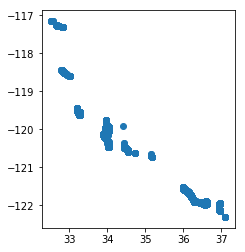

In [5]:
kelper.plot()

In [3]:
a = gpd.read_file('../../data/MAN_CA_KelpAdmin/MAN_CA_KelpAdmin.shp')

In [4]:
a.head()

,KelpBed,Exclusions,Status,Shape_Leng,Lessee,TermEnds,Shape_Le_1,Shape_Area,geometry
0,1,None,OPEN,47791.266131,None,None,47791.266131,4.429537e+07,"POLYGON ((269959.375 -601949.5, 269971.8438000..."
1,2,None,OPEN,162157.655298,None,None,162157.655298,1.413336e+08,"POLYGON ((262135.2813000008 -582135, 262134.93..."
2,3,None,LEASED,35916.074628,"KNOCEAN Sciences, Inc.",2017-04-11,35916.074628,6.300310e+07,"POLYGON ((251498.261500001 -580250.8181999996,..."
3,4,None,LEASABLE,101285.862462,None,None,101285.862462,9.546491e+07,POLYGON ((256441.9941999987 -570015.5066999998...
4,5,None,LEASABLE,41830.085472,None,None,41830.085472,6.637086e+07,POLYGON ((249535.8663999997 -556316.0986000001...


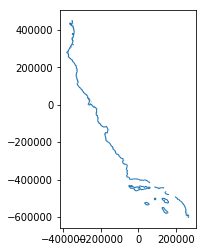

In [5]:
a.plot()

In [10]:
a.shape

(87, 9)

In [132]:
kelp_points = []
for f in os.listdir('../../data/kelp/all_kelp'):
    fname, ext = os.path.splitext(f)
    if ext == ".shp":
        print(fname+ext)
        kelp_file = gpd.read_file('../../data/kelp/all_kelp/'+fname+ext)
        kelp_file = kelp_file.set_geometry('geometry').to_crs({'init':'epsg:4326'})
        for i in range(kelp_file.shape[0]):
            #print("i",i)
            if type(kelp_file.iloc[i].geometry) == MultiPolygon:
                polygons = list(kelp_file.iloc[i].geometry)
                kelp_points.extend(polygons)
            elif type(kelp_file.iloc[i].geometry) == Polygon:
                polygons = kelp_file.iloc[i].geometry
                kelp_points.append(polygons)
kelp_points = pd.Series(kelp_points)
aerial_kelp = pd.DataFrame({'geometry':kelp_points})
aerial_kelp = gpd.GeoDataFrame(aerial_kelp, crs = {'init' :'epsg:4326'}, geometry=kelp_points)
print(aerial_kelp.shape)
aerial_kelp.head()

BIO_CA_Kelp2014.shp
BIO_CA_Kelp2015.shp
BIO_CA_Kelp2016.shp
(4418634, 1)


,geometry
0,POLYGON ((-117.1615439609101 32.55037319228528...
1,"POLYGON ((-117.162073917011 32.55042282280107,..."
2,POLYGON ((-117.1616276847815 32.55041146824276...
3,"POLYGON ((-117.1616914322351 32.5504130904318,..."
4,POLYGON ((-117.1621125979007 32.55053224304624...


# create grid of CA

In [133]:
def squarify(point, increment):
    return Polygon([(point[0], point[1]),
     (point[0] + increment, point[1]), 
     (point[0] + increment, point[1] + increment), 
     (point[0], point[1] + increment)])

def desquarify(left_vertices, right_vertices, square_length):
    x_num = round((right_vertices[0] - left_vertices[0])/square_length, 0)
    y_num = round((right_vertices[1] - left_vertices[1])/square_length, 0)
    x_lengths = np.linspace(left_vertices[0], right_vertices[0]-square_length, x_num)
    y_lengths = np.linspace(left_vertices[1], right_vertices[1]-square_length, y_num)
    return [p for p in product(x_lengths, y_lengths)]

In [134]:
def haversine(p1,p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Source: https://gis.stackexchange.com/a/56589/15183
    """
    lon1 = p1[0]
    lat1 = p1[1]
    lon2 = p2[0]
    lat2 = p2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6373 * c
    return km

In [135]:
#just get the base distance for one point b/c this will be close to the the right scaling
#add half a degee in lat and lon to get the second point
def get_distance_ratio(shape):
    p1 = list(shape.representative_point().coords)[0]
    p2 = (p1[0]+0.5,p1[1]+0.5)
    d_km = haversine(p1,p2)
    #just get the base distance for one point b/c this will be close to the the right scaling for all p2s
    base_coord_d=Point(p1).distance(Point(p2))
    return d_km/base_coord_d
def get_distance_to_object(shape, areas):
    distance_ratio = get_distance_ratio(shape)
    distance = np.min([shape.distance(i) for i in land.geometry])*distance_ratio
    return distance

In [141]:
#create vertices for California
#roughly the bounds of california going out 8km past cape mendocino
width = .01
#(32.534343,-124.511849),(42.00,-117.123885)
grid_bottomleft_vertices = desquarify((-124.511849,32.534343),(-117.123885,42), width)
grid = [squarify(i, width) for i in grid_bottomleft_vertices]
grid_df = gpd.GeoDataFrame(geometry=grid, crs = {'init' : 'epsg:4326'})
grid_df["polygon_id"] = range(len(grid))

# Cull data to just areas near coast and not on land
#import state shapefiles
states = gpd.read_file('../data/state_shapefiles/cb_2017_us_state_20m.shp')
land = states[states['STATEFP'] == '06']
# change the CRS
land = land.set_geometry('geometry').to_crs({'init':'epsg:4326'})

# cull polygons on land
print("before culling land there are {} rows".format(grid_df.shape[0]))
grid_df = gpd.sjoin(grid_df, land, op='within', how='left')
grid_df.fillna(-99999, inplace=True)
grid_df = grid_df[grid_df['index_right'] <0]
print("after culling land there are {} rows".format(grid_df.shape[0]))
grid_df = grid_df.iloc[:,:2]

#cull polygons far from shore
#EEZ extends 3 nautical miles (5.556 km) from coast. 
eez = 5.556
print("before culling far away sites there are {} rows".format(grid_df.shape[0]))
grid_df['land_distance'] = grid_df.geometry.apply(lambda x: get_distance_to_object(x,land.geometry))
grid_df = grid_df[grid_df['land_distance'] <eez]
print("after culling far away sites there are {} rows".format(grid_df.shape[0]))
print(grid_df.shape)
print(len(grid_df.polygon_id.unique()))
grid_df.head()

/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


before culling land there are 699833 rows
after culling land there are 370668 rows
before culling far away sites there are 370668 rows
after culling far away sites there are 19160 rows
(19160, 3)
19160


,geometry,polygon_id,land_distance
4576,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725
4577,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421
4578,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305
4579,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576
4580,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229


In [142]:
grid_df = gpd.sjoin(aerial_kelp, grid_df, op='within', how='right')
grid_df['hasKelp'] = np.isfinite(grid_df.index_left)
print(grid_df.shape)
grid_df.head()

(3675541, 5)


,index_left,geometry,polygon_id,land_distance,hasKelp
index_right,,,,,
11203,1306311.0,POLYGON ((-124.4018793468835 40.39073454545455...,11203,0.680733,True
11203,1306548.0,POLYGON ((-124.4018793468835 40.39073454545455...,11203,0.680733,True
11203,1306309.0,POLYGON ((-124.4018793468835 40.39073454545455...,11203,0.680733,True
11203,1306310.0,POLYGON ((-124.4018793468835 40.39073454545455...,11203,0.680733,True
11203,1306549.0,POLYGON ((-124.4018793468835 40.39073454545455...,11203,0.680733,True


In [143]:
grid_df = grid_df.dissolve(by=grid_df.polygon_id)
print(grid_df[grid_df.hasKelp == True].shape)
grid_df.shape

(1829, 5)


(19160, 5)

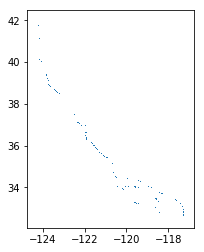

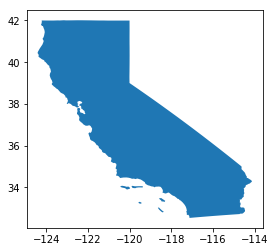

In [146]:
grid_df[grid_df.hasKelp == True].plot()
land.plot()

In [144]:
grid_df.to_pickle('../data/pickles/aerial_kelp_hundreththkm.pkl')

# Read PAR data

In [91]:
par_dir = '../../data/par/par_data/'
par_data = {}
month_re = 'A201[7|8]([\d]+)*'
for f in os.listdir(par_dir):
    par = xr.open_dataset(par_dir+f).to_dataframe() # units are E/m^2/day
    par.reset_index(inplace=True)
    geom = par.apply(lambda x : Point([x['lon'],x['lat']]), axis=1)
    par = gpd.GeoDataFrame(par, crs = {'init' :'epsg:4326'}, geometry=geom)
    par.drop(['lat','lon'], axis=1, inplace = True)
    month = int(re.match(month_re, f).groups()[0])
    par_data[month] = par

In [92]:
par_data.keys()
par_data[3].head()

,par,geometry
0,29.941998,POINT (-124.4791717529297 42.1875)
1,29.439999,POINT (-124.4375076293945 42.1875)
2,28.939999,POINT (-124.3958358764648 42.1875)
3,28.003998,POINT (-124.3541717529297 42.1875)
4,28.003998,POINT (-124.3125076293945 42.1875)


# Read Kd data

In [93]:
kd_dir = '../../data/kd/kd_data/'
kd_data = {}
month_re = 'A201[7|8]([\d]+)*'
for f in os.listdir(kd_dir):
    kd = xr.open_dataset(kd_dir+f).to_dataframe() # units are m^-1
    kd.reset_index(inplace=True)
    geom = kd.apply(lambda x : Point([x['lon'],x['lat']]), axis=1)
    kd = gpd.GeoDataFrame(kd, crs = {'init' :'epsg:4326'}, geometry=geom)
    kd.drop(['lat','lon'], axis=1, inplace = True)
    month = int(re.match(month_re, f).groups()[0])
    kd_data[month] = kd

In [94]:
kd_data.keys()
kd_data[7].head()

,Kd_490,geometry
0,1.1242,POINT (-124.4791717529297 42.1875)
1,0.9228,POINT (-124.4375076293945 42.1875)
2,0.1162,POINT (-124.3958358764648 42.1875)
3,NaN,POINT (-124.3541717529297 42.1875)
4,NaN,POINT (-124.3125076293945 42.1875)


In [95]:
light_data = {}
for i in range(1,13,1):
    joined = gpd.sjoin(kd_data[i], par_data[i], op="contains")
    joined.drop(['index_right'], axis=1, inplace=True)
    light_data[i] = joined 

In [207]:
#for i in range(1,13,1):
#    print(kd_data[i].iloc[0])
#plt.hist(kd_data[1].Kd_490)

In [212]:
def light_at_depth(par, kd, z):
    return par*np.exp(-kd*z)

light_threshold = 50
# create an array for each lat/long point. default to 0 depth and 0 light
z_min_light = np.array([0]*light_data[1].shape[0]) # need to make np array for future calcs
# i represents the depth in meters
for i in range(5,551,5):
    print(i)
    # create an array for all coords. We will add to this for each month to get the total light at each depth in a year
    # then we can compare to the standing best value to get the minimum depth
    year_light = np.array([0]*light_data[1].shape[0]) #changed for np calcs later
    # j represents the month number
    for j in range(1,13,1):
        month_light = light_data[j].apply(lambda x: 30.4*light_at_depth(x.par, x.Kd_490, i), axis=1)
        year_light += month_light
        #print(year_light[:3])
    gt_light_threshold = np.where(np.greater(year_light, light_threshold) == True)[0]
    if len(gt_light_threshold) == 0:
        break
    #print(year_light[gt_light_threshold][:3])
    z_min_light[gt_light_threshold] = i
    print(gt_light_threshold[:5])


5


/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


[  0   1 180 181 360]
10
[  0   1 180 181 360]
15
[  0   1 180 181 360]
20
[  0   1 180 181 360]
25
[  0   1 180 181 360]
30
[  0   1 180 181 360]
35
[  0   1 180 181 360]
40
[ 360  724 1800 1980 2160]
45
[1980 2340 2520 2700 2880]
50
[2340 2520 2880 3060 3240]
55
[8280 8460 8461 8640 8641]
60
[9000 9180 9181 9360 9361]
65
[9542 9720 9721 9722 9900]
70
[ 9900 10080 10081 10082 10260]
75
[10260 10261 10440 10441 10442]
80
[10620 10621 10800 10801 10802]
85
[10800 10980 10981 11160 11161]
90
[11160 11340 11341 11520 11521]
95
[11340 11880 12060 12240 12600]
100
[25577 25578 25579 25580 25583]
105
[25762 25763 25764 25765 25766]
110
[26464 26465 26640 26641 26642]
115
[26640 26641 26642 26822 26823]
120
[26822 27002 27003 27004 27183]
125
[27002 27726 27727 27902 27903]
130
[27905 27906 27907 28080 28087]
135
[27905 27906 28265 28266 28443]
140
[28800 28981 28982 30960 34020]
145
[28800 34560 34563 34740 34741]
150
[28800 34740 34743 34744 34920]
155
[28800 34920 34921 34922 34923]
160
[2

In [218]:
min_light = pd.DataFrame({'geometry':geom,'z_min_light':z_min_light})

(array([31690.,  1154.,  1880.,  2075.,  1915.,  1368.,  1262.,   467.,
           54.,    75.]),
 array([  0. ,  20.5,  41. ,  61.5,  82. , 102.5, 123. , 143.5, 164. ,
        184.5, 205. ]),
 <a list of 10 Patch objects>)

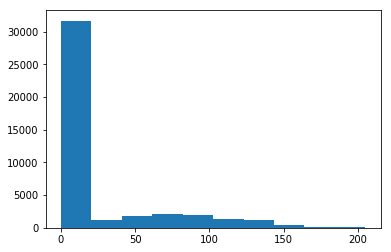

In [216]:
plt.hist(min_light.z_min_light)

In [219]:
min_light.head()
min_light.to_pickle('../data/pickles/min_light.pkl')

# Read mixed layer data

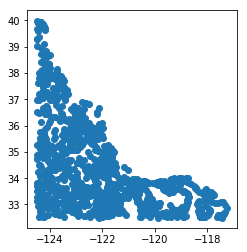

In [87]:
mixedl = xr.open_dataset('../../data/mixed_layer/Argo_mixedlayers_all_05092018.nc').to_dataframe()
#da - density algorithm
#dt - density threshold algorithm
#ta - temperature algorithm
mixedl = mixedl[(mixedl.profilelat>32.5) & (mixedl.profilelat<42.2) \
                & (mixedl.profilelon>-124.5) & (mixedl.profilelon<-117)]
geom = mixedl.apply(lambda x : Point([x['profilelon'],x['profilelat']]), axis=1)
mixedl = gpd.GeoDataFrame(mixedl, crs = {'init' :'epsg:4326'}, geometry=geom)
mixedl.plot()

In [88]:
mixedl['mean_mld'] = mixedl.apply(lambda x: (x.da_mld + x.dt_mld + x.ta_mld + x.tt_mld)/4, axis=1)
mixedl = mixedl[['geometry','mean_mld']]
mixedl.head()

,geometry,mean_mld
iNPROF,,
2325,POINT (-123.031997680664 36.3499984741211),17.643838
2326,POINT (-122.782997131348 36.2389984130859),19.306555
2327,POINT (-122.656997680664 36.0320014953613),17.594704
2328,POINT (-122.785003662109 35.9490013122559),31.267630
2329,POINT (-122.830001831055 35.9910011291504),30.126088


In [89]:
mixedl.head()

,geometry,mean_mld
iNPROF,,
2325,POINT (-123.031997680664 36.3499984741211),17.643838
2326,POINT (-122.782997131348 36.2389984130859),19.306555
2327,POINT (-122.656997680664 36.0320014953613),17.594704
2328,POINT (-122.785003662109 35.9490013122559),31.267630
2329,POINT (-122.830001831055 35.9910011291504),30.126088


In [102]:
mixedl.to_pickle('../data/pickles/mixedl.pkl')

# Read shoretype data

In [13]:
shoretypes = gpd.read_file('../../data/substrate/shoretypes/HAB_CA_ShoreTypes.shp')
#some geometry elements were null
shoretypes = shoretypes[shoretypes.geometry.notnull()]
print(shoretypes.shape)
shoretypes = shoretypes.set_geometry('geometry').to_crs({'init':'epsg:4326'})
shoretypes = shoretypes[['s1name','mapclass','geometry']]
#shoretypes.to_pickle('../data/pickles/shoretypes.pkl')
shoretypes.head()

(13224, 23)


,s1name,mapclass,geometry
0,salt and brackish water marshes,Coastal Marsh,LINESTRING (-122.2670655780284 38.140429319407...
1,salt and brackish water marshes,Coastal Marsh,LINESTRING (-122.2654327824122 38.138064280339...
2,salt and brackish water marshes,Coastal Marsh,LINESTRING (-122.2650283879836 38.137904045875...
3,salt and brackish water marshes,Coastal Marsh,LINESTRING (-122.0594334809901 38.137692783103...
4,salt and brackish water marshes,Coastal Marsh,LINESTRING (-122.2645324469021 38.136904617132...


# Read substrate type

In [106]:
#print(fiona.listlayers('../../data/substrate/substrate/UpdatedCCSR_2015/Hab_ccsr_cscmp_2015.gdb'))
#substrate = gpd.read_file('../../data/substrate/substrate/UpdatedCCSR_2015/Hab_ccsr_cscmp_2015.gdb',\
#                          layer=0)
#substrate.head()

In [29]:
substrate_points = []
for f in os.listdir('../../data/substrate/substrate'):
    fname, ext = os.path.splitext(f)
    if ext == ".shp":
        print(fname+ext)
        substrate_file = gpd.read_file('../../data/substrate/substrate/'+fname+ext)
        substrate_file = substrate_file.set_geometry('geometry').to_crs({'init':'epsg:4326'})
        for i in range(substrate_file.shape[0]):
            #print("i",i)
            if type(substrate_file.iloc[i].geometry) == MultiPolygon:
                polygons = list(substrate_file.iloc[i].geometry)
                substrate_points.extend(polygons)
            elif type(substrate_file.iloc[i].geometry) == Polygon:
                polygons = substrate_file.iloc[i].geometry
                substrate_points.append(polygons)
substrate_points = pd.Series(substrate_points)
substrate = pd.DataFrame({'geometry':substrate_points})
substrate = gpd.GeoDataFrame(substrate, crs = {'init' :'epsg:4326'}, geometry=substrate_points)
print(substrate.shape)
substrate.head()

HAB_NCCSR_Predicted_Substrate.shp
HAB_NCSR_PredictedSubstrateWDepth.shp
HAB_SCSR_PredictedSubstrateWDepth.shp
(187707, 1)


,geometry
0,"POLYGON ((-122.4091699822742 37.1833089494073,..."
1,"POLYGON ((-122.4091699822742 37.1833089494073,..."
2,POLYGON ((-122.4085165235676 37.18532580263099...
3,POLYGON ((-122.4016285748552 37.18251819230586...
4,POLYGON ((-122.4089328426767 37.18939703182896...


HAB_NCCSR_Predicted_Substrate.shp
HAB_NCSR_PredictedSubstrateWDepth.shp
HAB_SCSR_PredictedSubstrateWDepth.shp


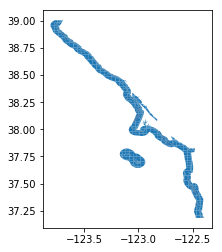

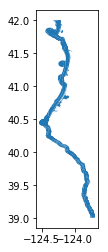

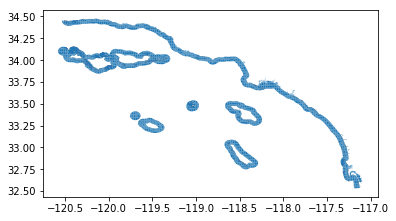

In [107]:
for f in os.listdir('../../data/substrate/substrate'):
    fname, ext = os.path.splitext(f)
    if ext == ".shp":
        print(fname+ext)
        substrate_file = gpd.read_file('../../data/substrate/substrate/'+fname+ext)
        substrate_file = substrate_file.set_geometry('geometry').to_crs({'init':'epsg:4326'})
        #print(substrate_file.head())
        substrate_file.plot()

# Read Oil platform locations

In [6]:
oilplats = gpd.read_file('../../data/human_factors/oilplatforms/OilPlatforms.shp')
oilplats = oilplats.set_geometry('geometry').to_crs({'init':'epsg:4326'})
#print(oilplats.head())
oilplats = oilplats[['NAME','geometry']]
oilplats.head()
oilplats.to_pickle('../data/pickles/oilplats.pkl')

   OBJECTID      NAME                                      geometry
0         1   HERMOSA  POINT (-120.6473931527499 34.45506677409544)
1         2   HARVEST   POINT (-120.6818245804602 34.4691266270206)
2         3     IRENE  POINT (-120.7304374501512 34.61040385174302)
3         4   HIDALGO  POINT (-120.7032955697988 34.49499618279855)
4         5  HERITAGE  POINT (-120.2801627404592 34.35038079300468)


# Read halibut trawl sites

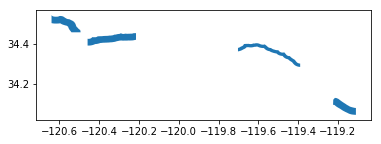

In [128]:
halibuttrawl = gpd.read_file('../../data/human_factors/halibuttrawl/MAN_SCSR_HalibutTrawlGrounds.shp')
halibuttrawl = halibuttrawl.set_geometry('geometry').to_crs({'init':'epsg:4326'})
halibuttrawl = halibuttrawl[['Status','geometry']]
halibuttrawl.plot()
halibuttrawl.to_pickle('../data/pickles/halibuttrawl.pkl')

# Read in port locations

(97, 18)


,AREA_,PERIMETER,CALGNIS_,CALGNIS_ID,ID,FEAT_NAME,PORTCODE,BIOGEOGRP,COMMERCIAL,P_COUNTY,GNIS_ID,FEAT_TYPE,ELEVAT_FT,VARIANT,PORT_CAT1,PORT_CAT2,SOURCETHM,geometry
0,0.0,0.0,0.0,0.0,0.0,Princeton/Half Moon Bay,452,3,1,San Mateo,None,None,0,None,9,0,marine-inland-po,POINT (-122.4818381624374 37.50369895811731)
1,0.0,0.0,0.0,0.0,1.0,San Francisco,440,3,0,San Francisco,None,None,0,None,10,0,marine-inland-po,POINT (-122.4154958398751 37.80864004947038)
2,0.0,0.0,0.0,0.0,2.0,San Rafael,468,3,0,Marin,None,None,0,None,10,0,marine-inland-po,POINT (-122.4845924051878 37.97278085949092)
3,0.0,0.0,0.0,0.0,3.0,Marina del Rey,776,0,1,Los Angeles,None,None,0,None,5,0,marine-inland-po,POINT (-118.4488149023916 33.96830655874205)
4,0.0,0.0,2053.0,2053.0,1657928.0,Anchor Bay,427,0,1,Mendocino,06000601,ppl,120,Anchor Bay Settlement (US-M111/Point Arena/1947),0,0,marine-inland-po,POINT (-123.5777892473698 38.80268831610905)


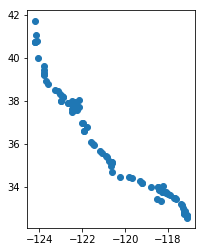

In [129]:
#outstanding questions on this
ports = gpd.read_file('../../data/human_factors/ports/CUL_CA_Ports.shp')
ports = ports.set_geometry('geometry').to_crs({'init':'epsg:4326'})
ports.plot()
print(ports.shape)
ports.head()
#ports.to_pickle('../data/pickles/ports.pkl')

(111, 8)
[ 1.  2. 10.  4.  3. 11.  8.  9.  5.  6.  7.]


,Major_Port,Port_Code,Port_Name,Coastal_In,County_Cod,Lat_DD,Long_DD,geometry
0,1.0,201.0,CRESCENT CITY,Y,8.0,41.755948,-124.201747,POINT (-349881.1890999991 423123.8949999996)
1,1.0,204.0,ORICK,N,12.0,41.286790,-124.059794,POINT (-340295.8079000004 370614.5822000001)
2,1.0,210.0,KLAMATH,N,8.0,41.526509,-124.038407,POINT (-337371.7542000003 397108.8209000006)
3,2.0,211.0,ALBION,Y,23.0,39.223512,-123.768625,POINT (-325009.2906999998 140640.9363000002)
4,1.0,212.0,ARCATA,N,12.0,40.866517,-124.082840,POINT (-344234.3618000001 324097.7916000001)


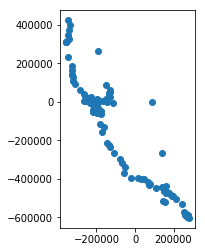

In [131]:
#outstanding questions on this
ports = gpd.read_file('../../data/human_factors/ports_cfis/CUL_CA_Ports_CFIS.shp')
ports = ports.set_geometry('geometry').to_crs({'init':'epsg:4326'})
ports.plot()
print(ports.shape)
print(ports.Major_Port.unique())
ports.head()
#ports.to_pickle('../data/pickles/ports.pkl')

# Read marinas

(321, 6)


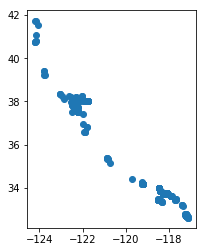

In [4]:
marinas = gpd.read_file('../../data/human_factors/marinas/CUL_CA_Marinas_DBW.shp')
marinas = marinas.set_geometry('geometry').to_crs({'init':'epsg:4326'})
print(marinas.shape)
#print(marinas.head())
marinas.plot()
marinas = marinas[['Name','geometry']]
marinas.head()
marinas.to_pickle('../data/pickles/marinas.pkl')

# Read boat launch sites

(124, 5)


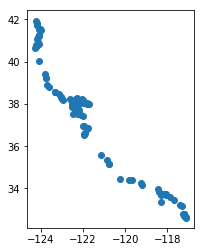

In [139]:
boatlaunches = gpd.read_file('../../data/human_factors/boatlaunchsites/CUL_CA_BoatLaunchSites_DBW.shp')
boatlaunches = boatlaunches.set_geometry('geometry').to_crs({'init':'epsg:4326'})
print(boatlaunches.shape)
boatlaunches.plot()
boatlaunches = boatlaunches[['Type','geometry']]
boatlaunches.head()
boatlaunches.to_pickle('../data/pickles/boatlaunches.pkl')

# Read fishing piers

(200, 5)


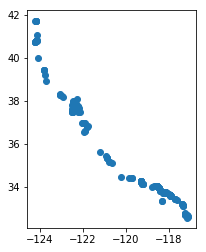

In [8]:
piers = gpd.read_file('../../data/human_factors/piers/FishingPiers.shp')
piers = piers.set_geometry('geometry').to_crs({'init':'epsg:4326'})
print(piers.shape)
#print(piers.head())
piers.plot()
piers = piers[['PNT_NAME','geometry']]
piers.head()
piers.to_pickle('../data/pickles/piers.pkl')